# Building a tokenizer, block by block

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

Building a tokenizer, block by block
Ask a Question
Open In Colab
Open In Studio Lab
As we’ve seen in the previous sections, tokenization comprises several steps:

Normalization (any cleanup of the text that is deemed necessary, such as removing spaces or accents, Unicode normalization, etc.)
Pre-tokenization (splitting the input into words)
Running the input through the model (using the pre-tokenized words to produce a sequence of tokens)
Post-processing (adding the special tokens of the tokenizer, generating the attention mask and token type IDs)
As a reminder, here’s another look at the overall process:



In [1]:
!pip install datasets evaluate transformers[sentencepiece]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.8 MB/s eta 0:00:00


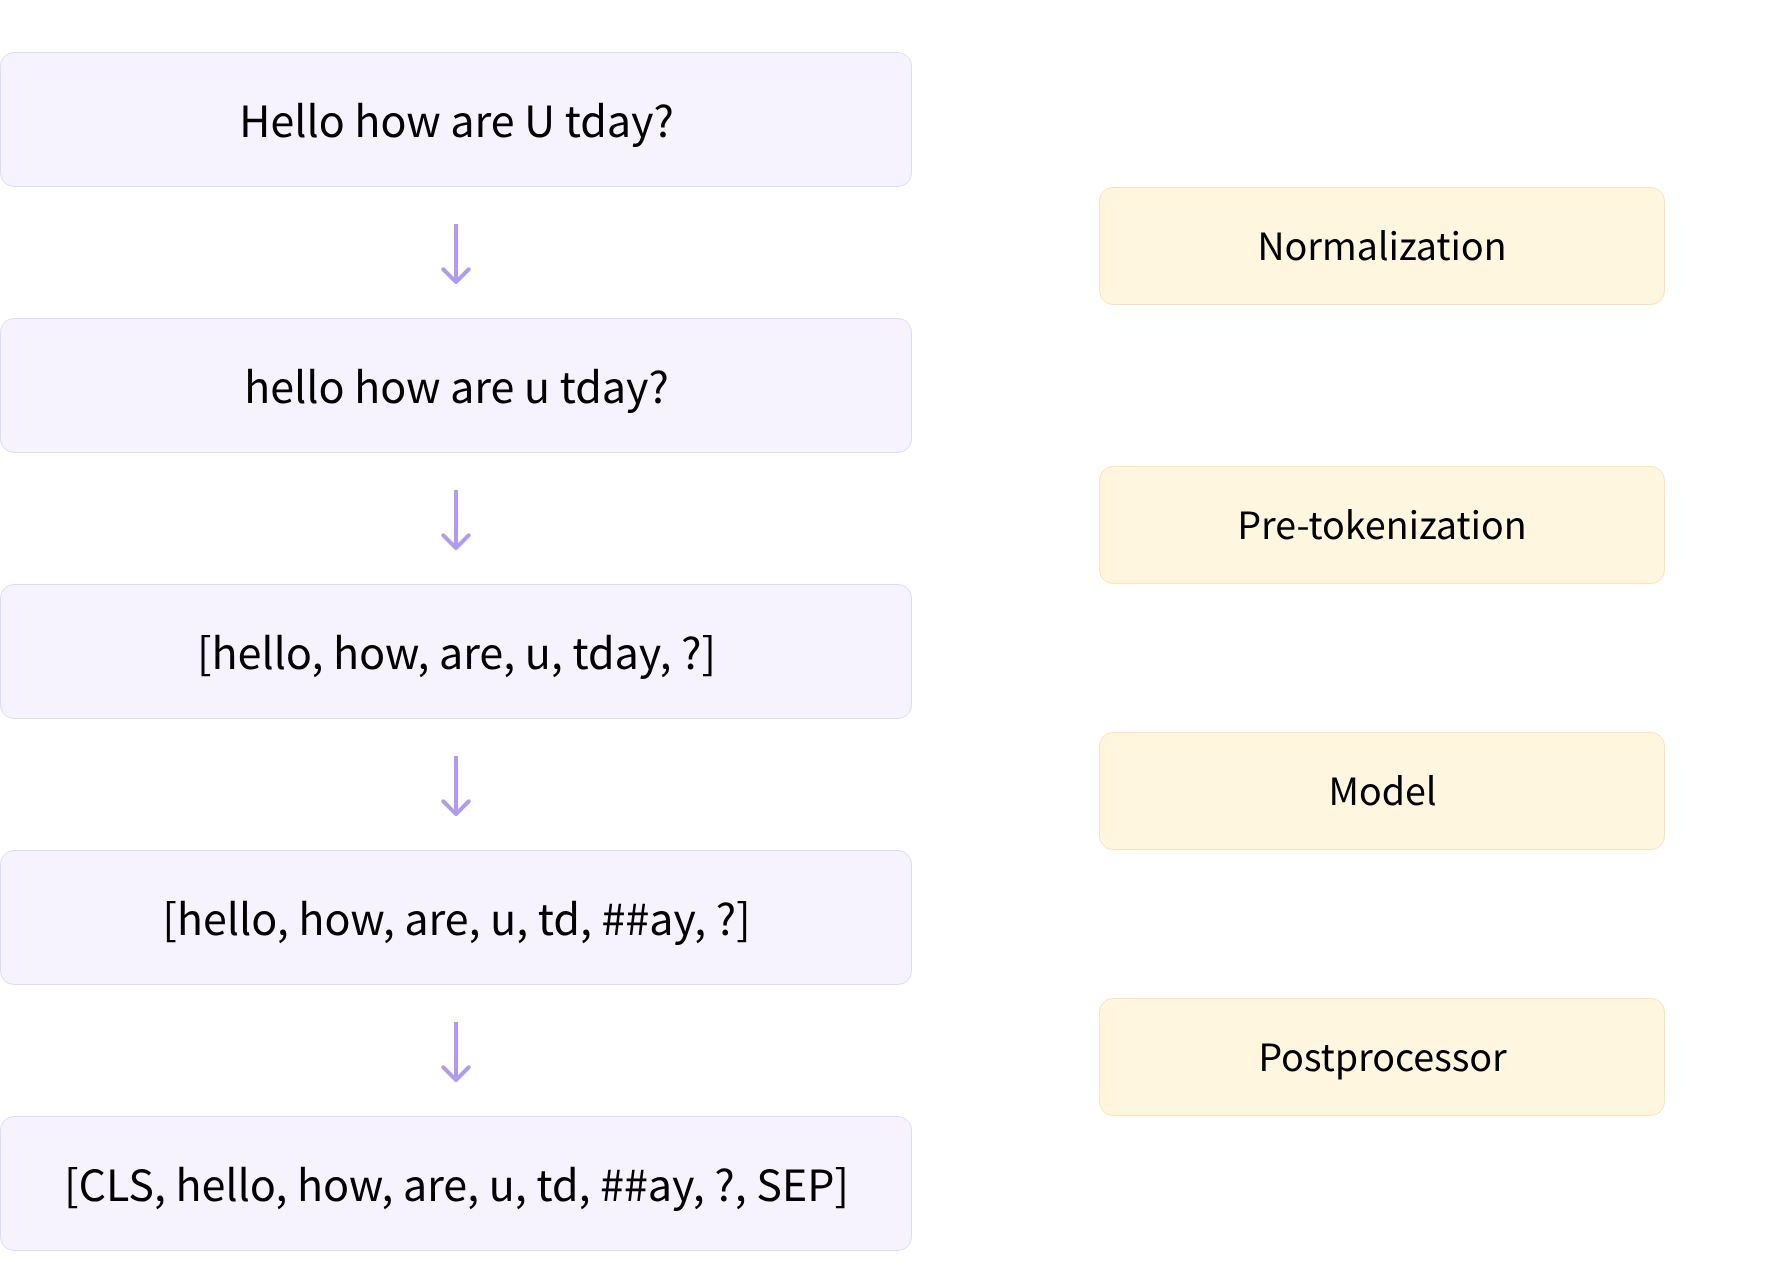

In [2]:
from datasets import load_dataset

dataset = load_dataset("wikitext", name="wikitext-2-raw-v1", split="train")


def get_training_corpus():
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["text"]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [3]:
with open("wikitext-2.txt", "w", encoding="utf-8") as f:
    for i in range(len(dataset)):
        f.write(dataset[i]["text"] + "\n")

In [4]:
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))

In [5]:
tokenizer.normalizer = normalizers.BertNormalizer(lowercase=True)

In [6]:
tokenizer.normalizer = normalizers.Sequence(
    [normalizers.NFD(), normalizers.Lowercase(), normalizers.StripAccents()]
)

In [7]:
print(tokenizer.normalizer.normalize_str("Héllò hôw are ü?"))

hello how are u?


In [8]:
tokenizer.pre_tokenizer = pre_tokenizers.BertPreTokenizer()

In [9]:
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

In [10]:
tokenizer.pre_tokenizer.pre_tokenize_str("Let's test my pre-tokenizer.")

[('Let', (0, 3)),
 ("'", (3, 4)),
 ('s', (4, 5)),
 ('test', (6, 10)),
 ('my', (11, 13)),
 ('pre', (14, 17)),
 ('-', (17, 18)),
 ('tokenizer', (18, 27)),
 ('.', (27, 28))]

In [11]:
pre_tokenizer = pre_tokenizers.WhitespaceSplit()
pre_tokenizer.pre_tokenize_str("Let's test my pre-tokenizer.")

[("Let's", (0, 5)),
 ('test', (6, 10)),
 ('my', (11, 13)),
 ('pre-tokenizer.', (14, 28))]

In [12]:
pre_tokenizer = pre_tokenizers.Sequence(
    [pre_tokenizers.WhitespaceSplit(), pre_tokenizers.Punctuation()]
)
pre_tokenizer.pre_tokenize_str("Let's test my pre-tokenizer.")

[('Let', (0, 3)),
 ("'", (3, 4)),
 ('s', (4, 5)),
 ('test', (6, 10)),
 ('my', (11, 13)),
 ('pre', (14, 17)),
 ('-', (17, 18)),
 ('tokenizer', (18, 27)),
 ('.', (27, 28))]

In [13]:
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.WordPieceTrainer(vocab_size=25000, special_tokens=special_tokens)

In [14]:
tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)

In [15]:
tokenizer.model = models.WordPiece(unk_token="[UNK]")
tokenizer.train(["wikitext-2.txt"], trainer=trainer)

In [16]:
encoding = tokenizer.encode("Let's test this tokenizer.")
print(encoding.tokens)

['let', "'", 's', 'test', 'this', 'tok', '##eni', '##zer', '.']


In [17]:
cls_token_id = tokenizer.token_to_id("[CLS]")
sep_token_id = tokenizer.token_to_id("[SEP]")
print(cls_token_id, sep_token_id)

2 3


In [18]:
tokenizer.post_processor = processors.TemplateProcessing(
    single=f"[CLS]:0 $A:0 [SEP]:0",
    pair=f"[CLS]:0 $A:0 [SEP]:0 $B:1 [SEP]:1",
    special_tokens=[("[CLS]", cls_token_id), ("[SEP]", sep_token_id)],
)

In [19]:
encoding = tokenizer.encode("Let's test this tokenizer.")
print(encoding.tokens)

['[CLS]', 'let', "'", 's', 'test', 'this', 'tok', '##eni', '##zer', '.', '[SEP]']


In [20]:
encoding = tokenizer.encode("Let's test this tokenizer...", "on a pair of sentences.")
print(encoding.tokens)
print(encoding.type_ids)

['[CLS]', 'let', "'", 's', 'test', 'this', 'tok', '##eni', '##zer', '...', '[SEP]', 'on', 'a', 'pair', 'of', 'sentences', '.', '[SEP]']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]


In [21]:
tokenizer.decoder = decoders.WordPiece(prefix="##")

In [22]:
tokenizer.decode(encoding.ids)

"let ' s test this tokenizer... on a pair of sentences."

In [23]:
tokenizer.save("tokenizer.json")

In [24]:
new_tokenizer = Tokenizer.from_file("tokenizer.json")

In [25]:
from transformers import PreTrainedTokenizerFast

wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tokenizer,
    # tokenizer_file="tokenizer.json", # You can load from the tokenizer file, alternatively
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)

In [26]:
from transformers import BertTokenizerFast

wrapped_tokenizer = BertTokenizerFast(tokenizer_object=tokenizer)

In [27]:
tokenizer = Tokenizer(models.BPE())

In [28]:
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)

In [29]:
tokenizer.pre_tokenizer.pre_tokenize_str("Let's test pre-tokenization!")

[('Let', (0, 3)),
 ("'s", (3, 5)),
 ('Ġtest', (5, 10)),
 ('Ġpre', (10, 14)),
 ('-', (14, 15)),
 ('tokenization', (15, 27)),
 ('!', (27, 28))]

In [30]:
trainer = trainers.BpeTrainer(vocab_size=25000, special_tokens=["<|endoftext|>"])
tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)

In [31]:
tokenizer.model = models.BPE()
tokenizer.train(["wikitext-2.txt"], trainer=trainer)

In [32]:
encoding = tokenizer.encode("Let's test this tokenizer.")
print(encoding.tokens)

['L', 'et', "'", 's', 'Ġtest', 'Ġthis', 'Ġto', 'ken', 'izer', '.']


In [33]:
tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)

In [34]:
sentence = "Let's test this tokenizer."
encoding = tokenizer.encode(sentence)
start, end = encoding.offsets[4]
sentence[start:end]

' test'

In [35]:
tokenizer.decoder = decoders.ByteLevel()

In [36]:
tokenizer.decode(encoding.ids)

"Let's test this tokenizer."

In [37]:
from transformers import PreTrainedTokenizerFast

wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tokenizer,
    bos_token="<|endoftext|>",
    eos_token="<|endoftext|>",
)

In [38]:
from transformers import GPT2TokenizerFast

wrapped_tokenizer = GPT2TokenizerFast(tokenizer_object=tokenizer)

In [39]:
tokenizer = Tokenizer(models.Unigram())

In [40]:
from tokenizers import Regex

tokenizer.normalizer = normalizers.Sequence(
    [
        normalizers.Replace("``", '"'),
        normalizers.Replace("''", '"'),
        normalizers.NFKD(),
        normalizers.StripAccents(),
        normalizers.Replace(Regex(" {2,}"), " "),
    ]
)

In [41]:
tokenizer.pre_tokenizer = pre_tokenizers.Metaspace()

In [42]:
tokenizer.pre_tokenizer.pre_tokenize_str("Let's test the pre-tokenizer!")

[("▁Let's", (0, 5)),
 ('▁test', (5, 10)),
 ('▁the', (10, 14)),
 ('▁pre-tokenizer!', (14, 29))]

In [43]:
special_tokens = ["<cls>", "<sep>", "<unk>", "<pad>", "<mask>", "<s>", "</s>"]
trainer = trainers.UnigramTrainer(
    vocab_size=25000, special_tokens=special_tokens, unk_token="<unk>"
)
tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)

In [44]:
tokenizer.model = models.Unigram()
tokenizer.train(["wikitext-2.txt"], trainer=trainer)

In [45]:
encoding = tokenizer.encode("Let's test this tokenizer.")
print(encoding.tokens)

['▁Let', "'", 's', '▁test', '▁this', '▁to', 'ken', 'izer', '.']


In [46]:
cls_token_id = tokenizer.token_to_id("<cls>")
sep_token_id = tokenizer.token_to_id("<sep>")
print(cls_token_id, sep_token_id)

0 1


In [47]:
tokenizer.post_processor = processors.TemplateProcessing(
    single="$A:0 <sep>:0 <cls>:2",
    pair="$A:0 <sep>:0 $B:1 <sep>:1 <cls>:2",
    special_tokens=[("<sep>", sep_token_id), ("<cls>", cls_token_id)],
)

In [48]:
encoding = tokenizer.encode("Let's test this tokenizer...", "on a pair of sentences!")
print(encoding.tokens)
print(encoding.type_ids)

['▁Let', "'", 's', '▁test', '▁this', '▁to', 'ken', 'izer', '.', '.', '.', '<sep>', '▁', 'on', '▁', 'a', '▁pair', '▁of', '▁sentence', 's', '!', '<sep>', '<cls>']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]


In [49]:
tokenizer.decoder = decoders.Metaspace()

In [50]:
from transformers import PreTrainedTokenizerFast

wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tokenizer,
    bos_token="<s>",
    eos_token="</s>",
    unk_token="<unk>",
    pad_token="<pad>",
    cls_token="<cls>",
    sep_token="<sep>",
    mask_token="<mask>",
    padding_side="left",
)

In [51]:
from transformers import XLNetTokenizerFast

wrapped_tokenizer = XLNetTokenizerFast(tokenizer_object=tokenizer)